In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [8]:
#IMPORT NEEDED LIBRARIES

from tensorflow.keras.datasets import cifar10
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_tuner import HyperParameters
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
import os

In [3]:
# LOAD THE CIFAR 10 DATASET AND NORMALIZE IT

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# PREPARE VALIDATION DATA

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)
print('Validation set shape:',X_valid.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training set shape: (40000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)


In [10]:
class Conv2DBatchNormReLU(tf.keras.layers.Layer):
    def __init__(self, filters, l2=2.5e-4, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
            use_bias=False,
            kernel_initializer=tf.keras.initializers.HeUniform(),
            kernel_regularizer=tf.keras.regularizers.l2(l2),
        )
        self.batch_norm = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9,
            beta_regularizer=tf.keras.regularizers.l2(l2),
            gamma_regularizer=tf.keras.regularizers.l2(l2)
        )

    def call(self, inputs, training=False):
        x = self.conv2d(inputs)
        x = self.batch_norm(x, training=training)
        return tf.nn.relu(x)


class ResNet9Block(tf.keras.layers.Layer):
    def __init__(self, filters, l2=2.5e-4, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.conv_bn_relu_1 = Conv2DBatchNormReLU(filters=filters, l2=l2, kernel_size=kernel_size)
        self.conv_bn_relu_2 = Conv2DBatchNormReLU(filters=filters, l2=l2, kernel_size=kernel_size)
        self.downsample = tf.keras.layers.Conv2D(filters=filters,
                                                 kernel_size=1,
                                                 strides=2,
                                                 padding='SAME',
                                                 use_bias=False,
                                                 kernel_regularizer=tf.keras.regularizers.l2(l2))
        self.batch_norm = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.9,
                                                              beta_regularizer=tf.keras.regularizers.l2(l2),
                                                              gamma_regularizer=tf.keras.regularizers.l2(l2))
        self.max_pool2d = tf.keras.layers.MaxPool2D(pool_size=2)

    def call(self, inputs, training=False):
        shortcut = self.downsample(inputs)
        shortcut = self.batch_norm(shortcut, training=training)

        x = self.conv_bn_relu_1(inputs, training=training)
        x = self.max_pool2d(x)
        x = self.conv_bn_relu_2(x, training=training)

        return tf.nn.relu(x + shortcut)

def build_resnet9_model(hp):
    input_shape = (32, 32, 3)
    num_classes = 10

    filters_1 = hp.Int("filters_1", min_value=32, max_value=128, step=32)
    filters_2 = hp.Int("filters_2", min_value=64, max_value=256, step=64)
    filters_3 = hp.Int("filters_3", min_value=128, max_value=512, step=64)
    filters_4 = hp.Int("filters_4", min_value=256, max_value=512, step=64)

    l2 = hp.Choice("l2", values=[1e-4, 2.5e-4, 5e-4])
    learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2DBatchNormReLU(filters_1, l2=l2)(inputs)
    x = ResNet9Block(filters_2, l2=l2)(x)

    x = Conv2DBatchNormReLU(filters_3, l2=l2)(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = ResNet9Block(filters_4, l2=l2)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(
        num_classes,
        activation="softmax",
        use_bias=False,
        kernel_regularizer=tf.keras.regularizers.l2(l2),
        kernel_initializer=tf.keras.initializers.HeUniform(),
    )(x)

    model = tf.keras.Model(inputs, x, name="ResNet9")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Directory to save the tuner state
tuner_directory = 'resnet9_tuning'
project_name = "resnet9_hyperparameter_tuning"

# Check if the directory exists and contains necessary files for resumption
if os.path.exists(tuner_directory) and os.path.isfile(os.path.join(tuner_directory, "oracle.json")):
    tuner = RandomSearch(
        build_resnet9_model,
        objective="val_accuracy",
        max_trials=10,
        executions_per_trial=2,
        directory=tuner_directory,
        project_name=project_name,
    )
    tuner.reload()
    print("Resumed previous search.")
else:
    tuner = RandomSearch(
        build_resnet9_model,
        objective="val_accuracy",
        max_trials=10,
        executions_per_trial=2,
        directory=tuner_directory,
        project_name=project_name,
    )
    print("Starting new search.")

# Model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('cifar_resnet9_model.keras', monitor='val_loss', save_best_only=True)

# Perform the search
tuner.search(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    epochs=10,
    batch_size=HyperParameters().Int("batch_size", min_value=32, max_value=128, step=32),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3), model_checkpoint],
)

# Get the best hyperparameters from the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters:
Filters 1: {best_hps.get('filters_1')}
Filters 2: {best_hps.get('filters_2')}
Filters 3: {best_hps.get('filters_3')}
Filters 4: {best_hps.get('filters_4')}
L2 Regularization: {best_hps.get('l2')}
Learning Rate: {best_hps.get('learning_rate')}
""")


Reloading Tuner from resnet9_tuning/resnet9_hyperparameter_tuning/tuner0.json
Starting new search.

Best hyperparameters:
Filters 1: 128
Filters 2: 64
Filters 3: 448
Filters 4: 448
L2 Regularization: 0.0001
Learning Rate: 0.001



In [15]:
# Build and train the best model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=10,
    batch_size=32,
    callbacks=[model_checkpoint]
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.4739 - loss: 2.0478 - val_accuracy: 0.6643 - val_loss: 1.4659
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.7039 - loss: 1.3049 - val_accuracy: 0.7154 - val_loss: 1.2498
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7759 - loss: 1.0918 - val_accuracy: 0.7465 - val_loss: 1.1589
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8140 - loss: 0.9753 - val_accuracy: 0.7945 - val_loss: 1.0369
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.8440 - loss: 0.8739 - val_accuracy: 0.7599 - val_loss: 1.1632
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.8760 - loss: 0.7855 - val_accuracy: 0.7709 - val_loss: 1.1017
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.8965 - loss: 0.7288 - val_accuracy: 0.7984 - val_loss: 1.0592
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9104 -

<Axes: >

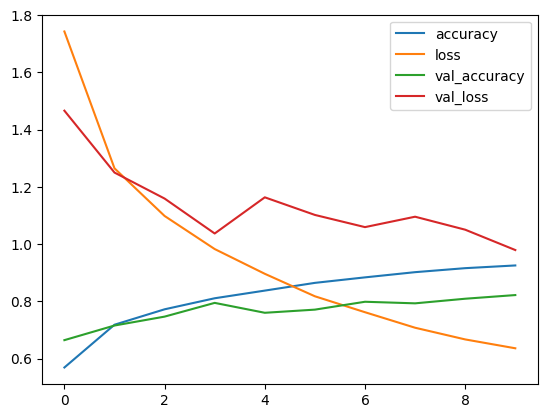

In [16]:
pd.DataFrame(history.history).plot()

In [17]:
# TESTING THE MODEL WITH TEST DATA AND PREPARE CLASSIFICATION REPORT (PRECISION , RECALL, F1-SCORE)

scores = best_model.evaluate(X_test, y_test)
y_pred = best_model.predict(X_test)
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
target = [class_names[i].format(i) for i in range(10)]

print("\n\nTesting Accuracy :",scores[1],"\n")
print(classification_report(y_test.flatten(), np.argmax(y_pred, axis=1), target_names=target))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8249 - loss: 0.9706
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


Testing Accuracy : 0.8235999941825867 

              precision    recall  f1-score   support

    airplane       0.87      0.79      0.83      1000
  automobile       0.94      0.88      0.90      1000
        bird       0.75      0.73      0.74      1000
         cat       0.67      0.71      0.69      1000
        deer       0.84      0.80      0.82      1000
         dog       0.76      0.76      0.76      1000
        frog       0.83      0.90      0.86      1000
       horse       0.82      0.88      0.85      1000
        ship       0.89      0.90      0.90      1000
       truck       0.88      0.89      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000

